<a href="https://colab.research.google.com/github/jenelaineDC/Master-Time-Series-Analysis-Forecasting/blob/main/PROPHET/Facebook_Prophet_Daily_Bike_Share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### SETTING UP ###

DOCUMENTATION: https://facebook.github.io/prophet/docs/quick_start.html

In [1]:
# Mount Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Path to the folder
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Modern Time Series Forecasting Techniques/Prophet

/content/drive/MyDrive/Python - Time Series Forecasting/Modern Time Series Forecasting Techniques/Prophet


In [3]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.model_selection import ParameterGrid
import itertools

In [4]:
# Prophet Library
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

### IMPORTING DATASET ###

The input to Prophet is always a dataframe with two columns: ds and y.

- The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.
- The y column must be numeric, and represents the measurement we wish to forecast.
- There is no need to set the date as the index

Data Source: https://www.kaggle.com/datasets/contactprad/bike-share-daily-data

**Background:**

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic,
environmental and health issues.

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into
a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important
events in the city could be detected via monitoring these data.

**Data Set:**

Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,
precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is
publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then
extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com.

In [5]:
df_train = pd.read_csv("Daily Bike Sharing training.csv")
df_future = pd.read_csv("Daily Bike Sharing future.csv")

# concatenate both
df = pd.concat([df_train, df_future])
df.reset_index(drop = True, inplace = True)
df.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,12/27/2012,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,NaN,NaN,NaN
727,728,12/28/2012,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,NaN,NaN,NaN
728,729,12/29/2012,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,NaN,NaN,NaN
729,730,12/30/2012,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,NaN,NaN,NaN
730,731,12/31/2012,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,NaN,NaN,NaN


In [6]:
print(df_train.shape)
print(df_future.shape)
print(df.shape)

(701, 16)
(30, 16)
(731, 16)


In [7]:
# Display information about the DataFrame, including data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      701 non-null    float64
 14  registered  701 non-null    float64
 15  cnt         701 non-null    float64
dtypes: float64(7), int64(8), object(1)
memory usage: 91.5+ KB


In [8]:
# Rename column cnt to y and dteday to ds
df = df.rename(columns = {'cnt': 'y',
                          'dteday': 'ds'})

# Change 'ds' into format YYYY-MM-DD
df['ds'] = pd.to_datetime(df['ds'], format = "%m/%d/%Y")
df.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331.0,654.0,985.0
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131.0,670.0,801.0
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120.0,1229.0,1349.0
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108.0,1454.0,1562.0
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82.0,1518.0,1600.0


In [9]:
df = pd.concat([
    df,
    pd.get_dummies(df['weathersit'], drop_first=True) #one hot encode the weathersit column
    .rename(columns={2: 'weathersit_2', 3: 'weathersit_3'}) #rename the new columns 2&3 to weathersit_2 and weathersit 3
], axis=1)

df.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y,weathersit_2,weathersit_3
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331.0,654.0,985.0,True,False
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131.0,670.0,801.0,True,False
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120.0,1229.0,1349.0,False,False
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108.0,1454.0,1562.0,False,False
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82.0,1518.0,1600.0,False,False


In [10]:
# Drop columns
df.drop(columns = ['instant', 'season', 'yr', 'mnth', 'weekday',
                   'casual', 'registered'], inplace = True)
df.head()

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985.0,True,False
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801.0,True,False
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349.0,False,False
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562.0,False,False
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600.0,False,False


In [11]:
# This was identified when I initially run the model and inspected the error
df[df.ds == '2012-10-29']

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3
667,2012-10-29,0,1,3,0.44,0.4394,0.88,0.3582,22.0,False,True


In [12]:
# Replace 29/30 of October 2012 with the values of 28th
to_replace = df.loc[df.ds == '2012-10-28'].y.values[0]
df.loc[df.ds == '2012-10-29', 'y'] = to_replace
df.loc[df.ds == '2012-10-30', 'y'] = to_replace

### EDA ###

- Based on the monthly seasonality plot, we have a positive upward trend during the months of January to May. Then peaks or platues during May til September. The demands starts to decrease by Oct.
- Based on the quarterly plot our highest is during Q3 followed by Q1. While our lowest is during the Q1.
- Based on the PACF, the most relevants are lag 1 to 6.

In [13]:
# Create df_temp with ds as the index
df_temp = df.copy()
df_temp.set_index('ds', inplace = True)

In [14]:
# Set the frequency of the DataFrame index to daily ("D")
df_temp.index.freq = "D"
df_temp.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', name='ds', length=731, freq='D')

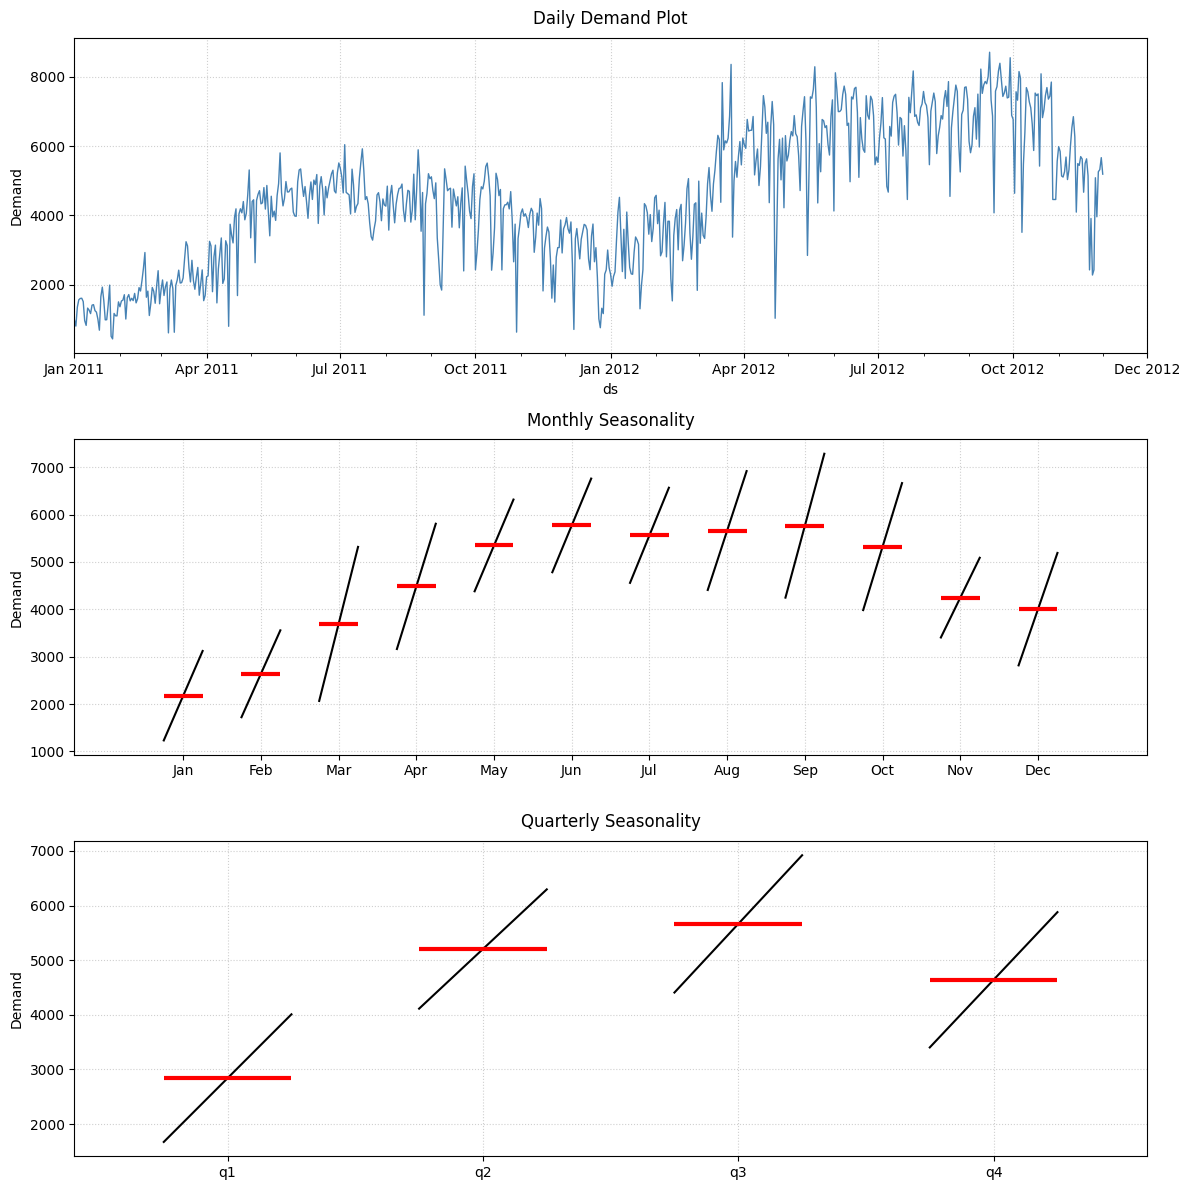

In [15]:
# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
plt.subplots_adjust(hspace=0.4)  # Adjust spacing between subplots

# Daily Plot
df_temp['y'].plot(ax=ax1, color='steelblue', linewidth=1)
ax1.set_title('Daily Demand Plot', fontsize=12, pad=10)
ax1.set_ylabel('Demand', fontsize=10)
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Monthly Seasonality Plot
month_plot(df_temp['y'].resample('ME').mean(), ylabel='Demand', ax=ax2)
ax2.set_title('Monthly Seasonality', fontsize=12, pad=10)
ax2.set_ylabel('Demand', fontsize=10)
ax2.grid(True, linestyle=':', alpha=0.6)

# Quarterly Seasonality Plot
quarter_plot(df_temp['y'].resample('QE').mean(), ylabel='Demand', ax=ax3)
ax3.set_title('Quarterly Seasonality', fontsize=12, pad=10)
ax3.set_ylabel('Demand', fontsize=10)
ax3.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

## PROPHET COMPONENTS ##

### Model Fitting ###

In [21]:
# Just the train data (excluding last 30 points)
train = df.iloc[:-30]

# Remove any NAs
train = train.dropna()

In [22]:
# Fitting the model
m1 = Prophet()
m1.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m1.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpssdy07bg/mwvse602.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpssdy07bg/idbhyyyi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31295', 'data', 'file=/tmp/tmpssdy07bg/mwvse602.json', 'init=/tmp/tmpssdy07bg/idbhyyyi.json', 'output', 'file=/tmp/tmpssdy07bg/prophet_modelkwhzv0g0/prophet_model-20250829121701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:17:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Forecasting

Note: By default, Prophet uses daily data. You need to adjust your data frequency if needed!

In [23]:
# Making future data
future = m1.make_future_dataframe(periods=30)
future.tail()

,ds
726,2012-12-27
727,2012-12-28
728,2012-12-29
729,2012-12-30
730,2012-12-31


In [24]:
# In sample predictions and future Forecasting
forecast = m1.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
726,2012-12-27,6056.462860,4798.329011,7297.222684
727,2012-12-28,6056.121919,4809.202710,7344.708023
728,2012-12-29,5957.882447,4679.274591,7259.460393
729,2012-12-30,5664.410586,4304.667191,6953.888679
730,2012-12-31,5822.493670,4659.610571,7103.300729


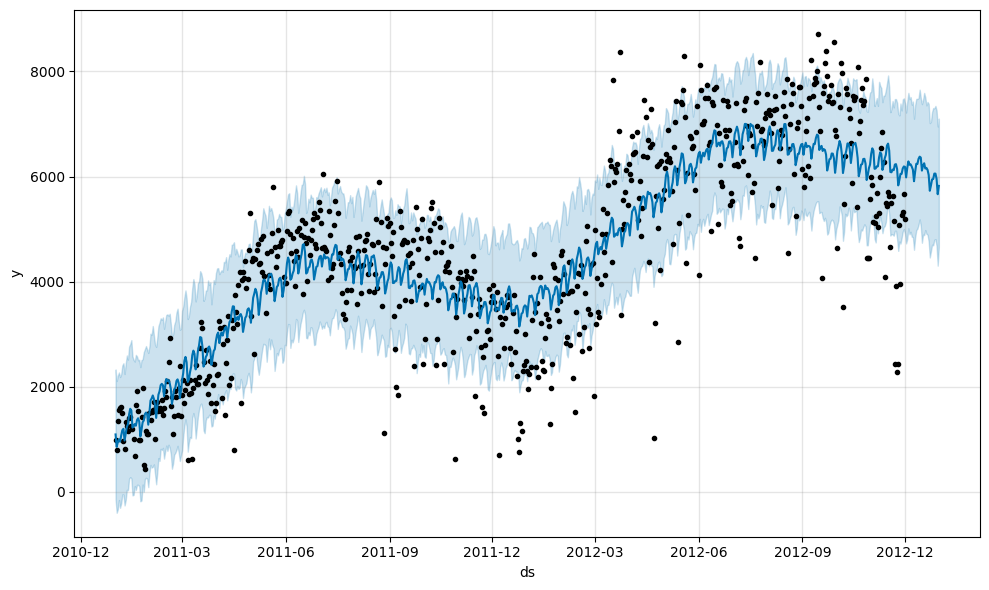

In [25]:
# plotting actuals and forecast
fig1 = m1.plot(forecast)

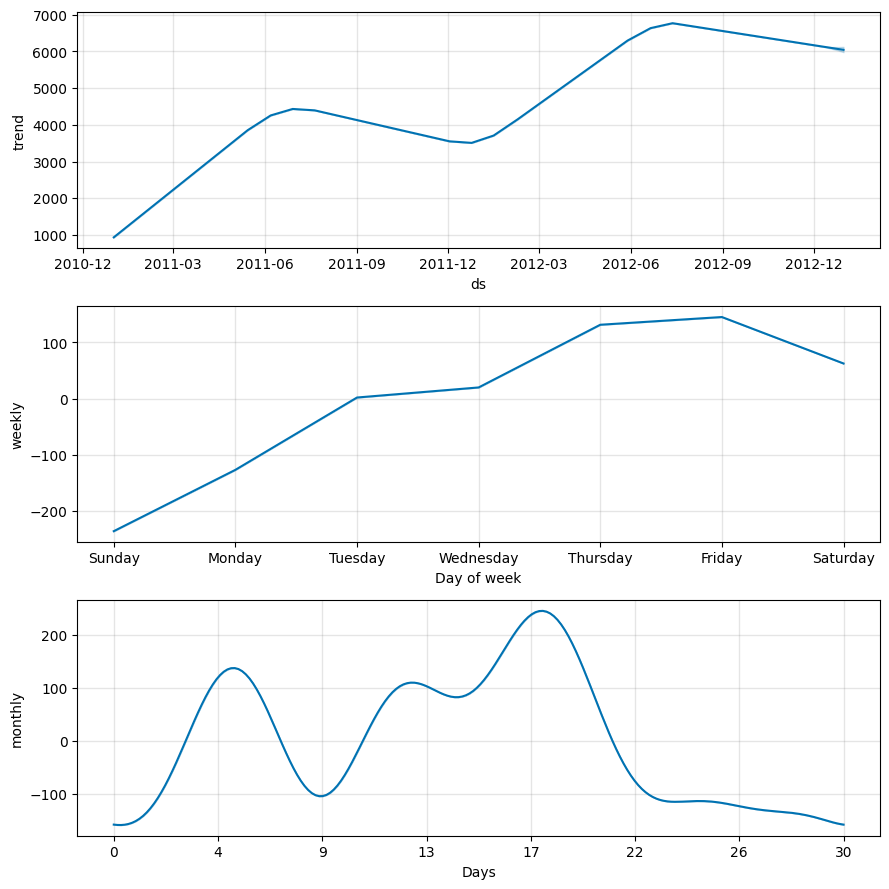

In [26]:
fig = m1.plot_components(forecast)

### Changepoints

Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history), then there are several input arguments you can use.

* Prior $\delta$ ~ LaPlace(0, $\tau$)
* Parameter Description: *changepoint_prior_scale*: $\tau$ controls the flexibility of the trend at changepoints. It is the scale parameter for the prior distribution of the rate at which the trend changes.
* Numerical Example: If you're forecasting sales around multiple new product launches, an increase in $\tau$ makes the model more responsive to these events. For example, setting $\tau=0.1$  rather than a more conservative value like 0.05 allows the model to detect and adapt to changes more aggressively.

By default 25 equally spaced changepoints are inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series. This default works in many situations but not all, and can be changed using the *changepoint_range* argument.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyneczxyg/6k5wrd60.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyneczxyg/etv1vi0c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87305', 'data', 'file=/tmp/tmpyneczxyg/6k5wrd60.json', 'init=/tmp/tmpyneczxyg/etv1vi0c.json', 'output', 'file=/tmp/tmpyneczxyg/prophet_modelz1i0uqgo/prophet_model-20250829064236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:42:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:42:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


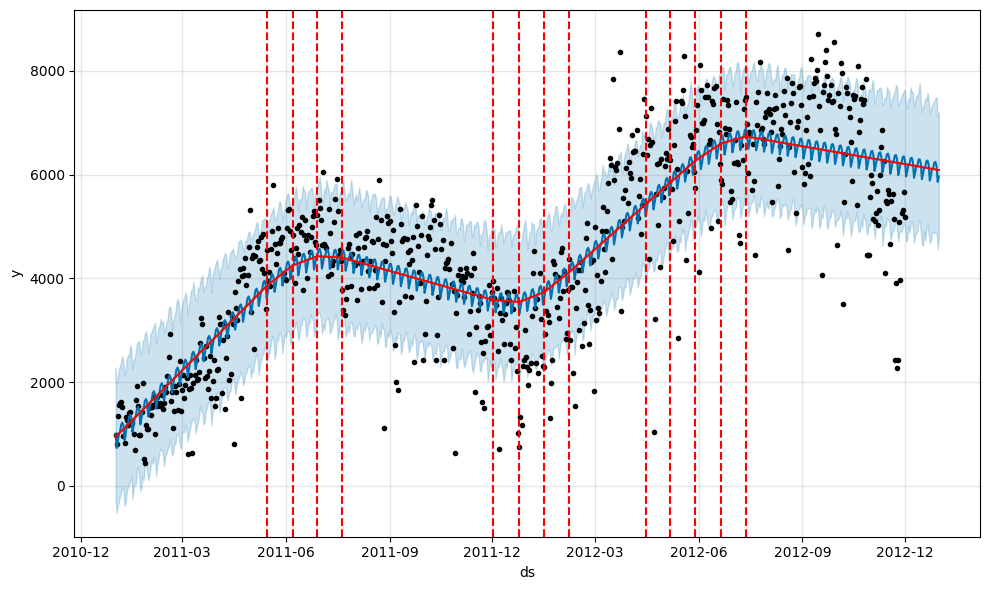

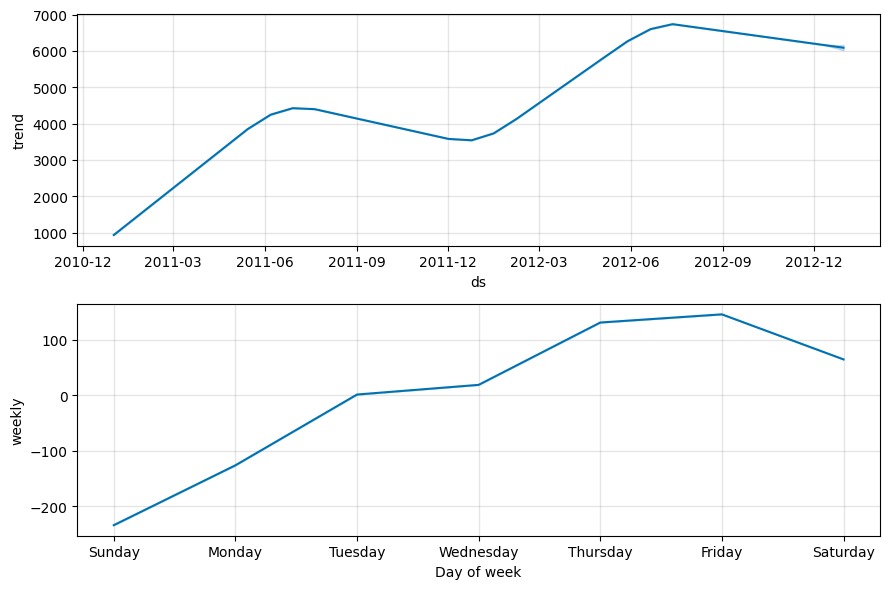

In [ ]:
# adding changepoints to the plot
m2 = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.8) # Default values are 0.05 and 0.8 respectively. Try scale = 0.001 and 100
forecast = m2.fit(train).predict(future)
fig = m2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m2, forecast)

fig = m2.plot_components(forecast)

### Seasonality

Seasonalities are estimated using a partial Fourier sum. See the paper for complete details, and this [figure on Wikipedia ](https://en.wikipedia.org/wiki/Fourier_series#/media/File:Fourier_Series.svg)for an illustration of how a partial Fourier sum can approximate an arbitrary periodic signal. The number of terms in the partial sum (the order) is a parameter that determines how quickly the seasonality can change.

* Smoothing Prior on seasonality $\beta$ ~ N(0, $\sigma^2$)
* Parameter Description: *seasonality_prior_scale* $\sigma$ affects how strongly the model fits the seasonal pattern of the data. It is used as the scale of the prior distribution for seasonal effects.
* Numerical Example: For a business with highly seasonal sales, such as a holiday store, emphasizing seasonal effects may be beneficial. Increasing $\sigma$ to a higher value, such as 15, can accentuate the seasonal components, capturing more pronounced seasonal fluctuations.

There are many other ways you can customize seasonalities. Check out the documentation [here](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html).

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyneczxyg/my9_h0r5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyneczxyg/qrduoysf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55404', 'data', 'file=/tmp/tmpyneczxyg/my9_h0r5.json', 'init=/tmp/tmpyneczxyg/qrduoysf.json', 'output', 'file=/tmp/tmpyneczxyg/prophet_modelnj3y2419/prophet_model-20250829064307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:43:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:43:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


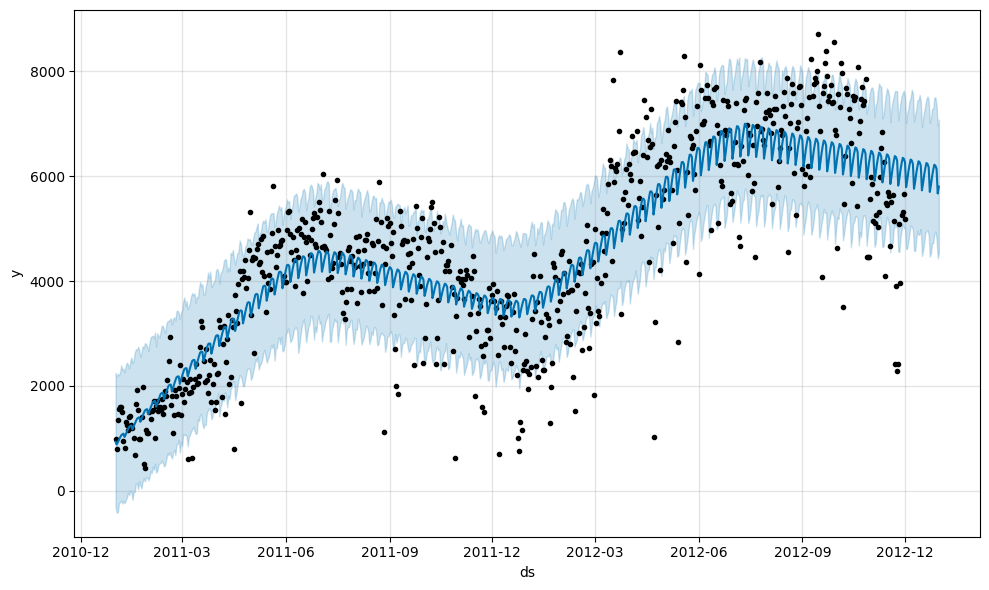

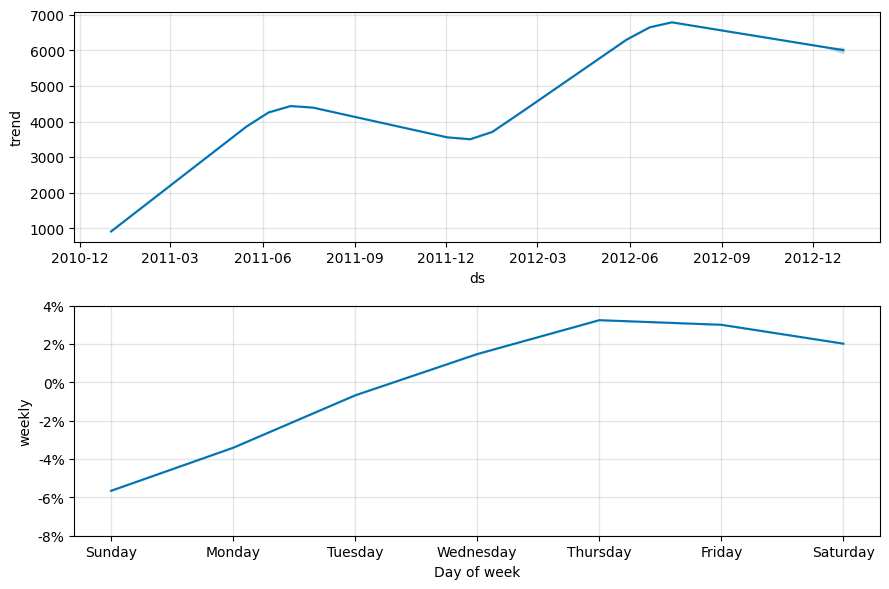

In [ ]:
# adding seasonality priors
m3 = Prophet(seasonality_mode='multiplicative', seasonality_prior_scale=10) # Default values are 'additive' and 10 respectively. Try 0.001
forecast = m3.fit(train).predict(future)
fig = m3.plot(forecast)

fig = m3.plot_components(forecast)

### Holidays

If you have holidays or other recurring events that you’d like to model, you must create a dataframe for them. It has two columns (holiday and ds) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won’t repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns lower_window and upper_window which extend the holiday out to [lower_window, upper_window] days around the date. For instance, if you wanted to include Christmas Eve in addition to Christmas you’d include lower_window=-1,upper_window=0. If you wanted to use Black Friday in addition to Thanksgiving, you’d include lower_window=0,upper_window=1. You can also include a column prior_scale to set the prior scale separately for each holiday.


* Prior $\kappa$ ~ N(0, $\gamma^2$)
* Parameter Description: $\gamma$ impacts how significantly holidays affect the forecast. It determines the flexibility of the model in adjusting for holiday effects.


There are many other ways you can customize Holidays. Check out the documentation [here](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html).

In [ ]:
# Independence Day Weekend
indep = pd.DataFrame({'holiday': 'Ind Weekend',
                     'ds': pd.to_datetime(['2011-07-02', '2012-07-01', '2012-07-07']),
                             'lower_window': -5,
                             'upper_window': 5})
# Black Friday Weekend
black = pd.DataFrame({'holiday': 'Black Friday',
                     'ds': pd.to_datetime(['2011-11-26', '2012-11-22', '2012-11-23', '2012-11-24', '2012-11-25']),
                             'lower_window': -3,
                             'upper_window': 3})

# Easter
easter = pd.DataFrame({'holiday': 'easter',
                     'ds': pd.to_datetime(['2011-04-24', '2012-04-08']),
                     'lower_window': -3,
                             'upper_window': 3})

# Combine all the holidays
holidays = pd.concat([indep, black, easter])
holidays

,holiday,ds,lower_window,upper_window
0,Ind Weekend,2011-07-02,-5,5
1,Ind Weekend,2012-07-01,-5,5
2,Ind Weekend,2012-07-07,-5,5
0,Black Friday,2011-11-26,-3,3
1,Black Friday,2012-11-22,-3,3
2,Black Friday,2012-11-23,-3,3
3,Black Friday,2012-11-24,-3,3
4,Black Friday,2012-11-25,-3,3
0,easter,2011-04-24,-3,3
1,easter,2012-04-08,-3,3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyneczxyg/2_621ilf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyneczxyg/8vywyaqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37103', 'data', 'file=/tmp/tmpyneczxyg/2_621ilf.json', 'init=/tmp/tmpyneczxyg/8vywyaqd.json', 'output', 'file=/tmp/tmpyneczxyg/prophet_modelht9wf891/prophet_model-20250829064441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:44:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:44:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


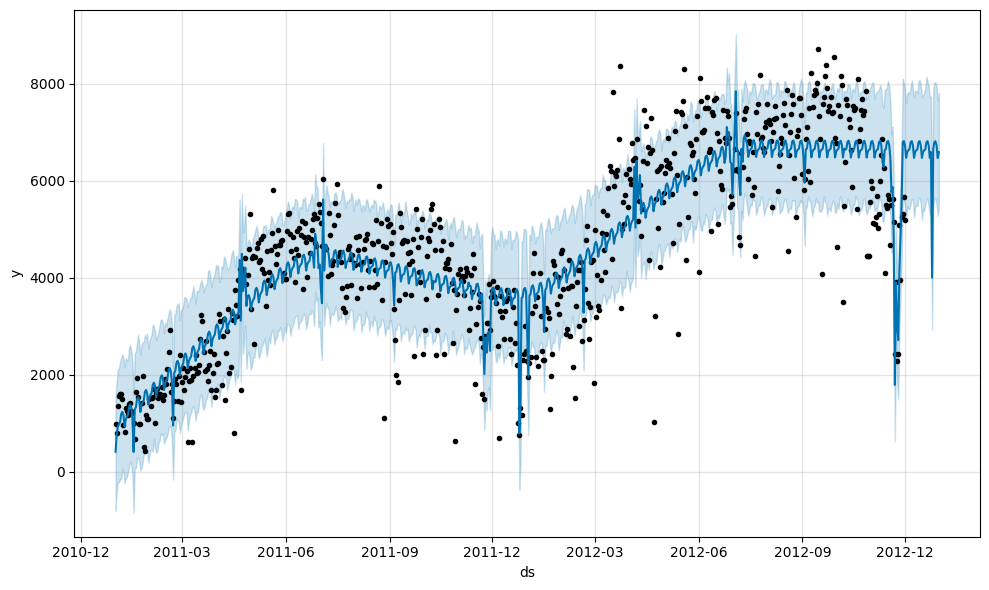

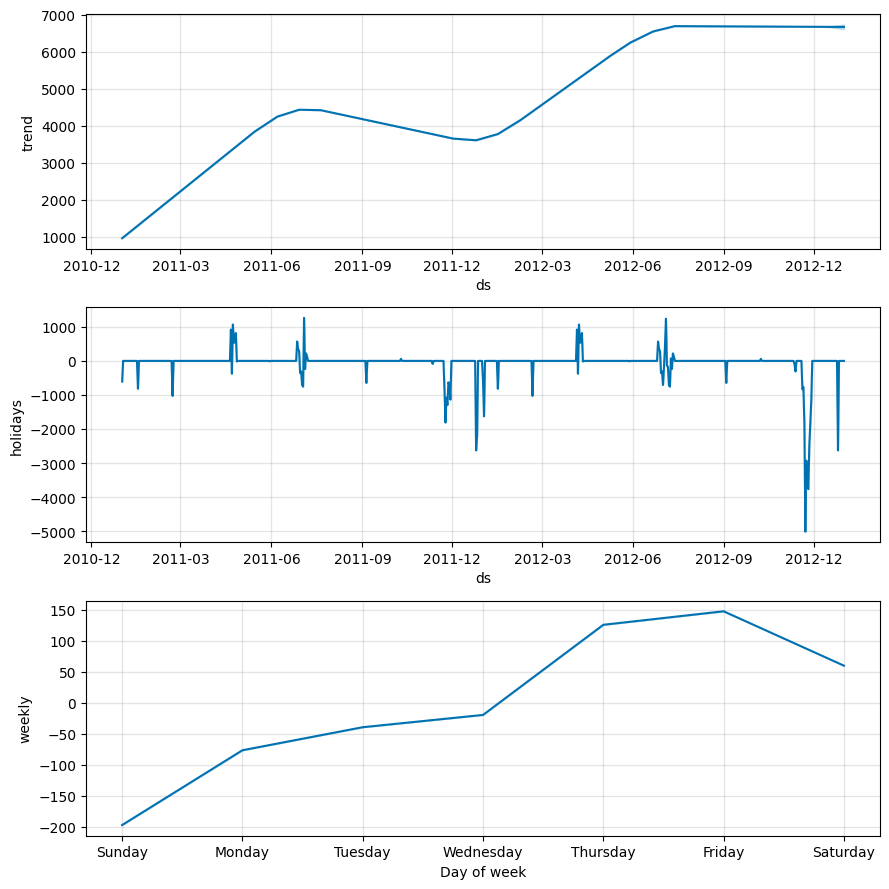

In [ ]:
# adding US holidays and a custom holiday

#You can change holidays to the custom holiday
m4 = Prophet(holidays=holidays  , holidays_prior_scale=10) # Default value is 10, which provides very little regularization. Reducing this parameter dampens holiday effects
m4.add_country_holidays(country_name='US')
forecast = m4.fit(train).predict(future)
fig = m4.plot(forecast)

fig = m4.plot_components(forecast)

## MODEL EVALUATION AND DIAGNOSTIC ##

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period).
* By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

### Building the Prophet Model ###

In [ ]:
# Building the Prophet model
m = Prophet(
    yearly_seasonality=True,     # Include yearly seasonality
    weekly_seasonality=True,     # Include weekly seasonality
    holidays=holidays,           # Include holiday effects
    seasonality_mode="multiplicative",  # Use multiplicative seasonality
    seasonality_prior_scale=10,  # Increase flexibility of seasonality
    holidays_prior_scale=10,     # Increase impact of holidays
    changepoint_prior_scale=0.05 # Control flexibility in detecting trend changes
)

# Add built in country holidays
m.add_country_holidays(country_name='US')

# Add monthly seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Add additional regressors (external factors) to the model
m.add_regressor("workingday")    # Whether it's a working day
m.add_regressor("temp")          # Temperature
m.add_regressor("atemp")         # Apparent temperature
m.add_regressor("hum")           # Humidity
m.add_regressor("windspeed")     # Wind speed
m.add_regressor("weathersit_2")  # Weather situation category 2
m.add_regressor("weathersit_3")  # Weather situation category 3

m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyneczxyg/ljeodaeu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyneczxyg/cim6cfdb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73090', 'data', 'file=/tmp/tmpyneczxyg/ljeodaeu.json', 'init=/tmp/tmpyneczxyg/cim6cfdb.json', 'output', 'file=/tmp/tmpyneczxyg/prophet_modelumhfla5k/prophet_model-20250829064803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:48:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:48:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Building Future Regressor ####

In [ ]:
# Drop columns 'ds' and 'y' from DataFrame df to create future_regressors
future_regressors = df.drop(columns = ['ds', 'y'])
# Drop rows with missing values (NaNs) from future_regressors
future_regressors = future_regressors.dropna()
# Reset the index
future_regressors.reset_index(drop = True, inplace = True)
future_regressors

,holiday,workingday,weathersit,temp,atemp,hum,windspeed,weathersit_2,weathersit_3
0,0,0,2,0.344167,0.363625,0.805833,0.160446,True,False
1,0,0,2,0.363478,0.353739,0.696087,0.248539,True,False
2,0,1,1,0.196364,0.189405,0.437273,0.248309,False,False
3,0,1,1,0.200000,0.212122,0.590435,0.160296,False,False
4,0,1,1,0.226957,0.229270,0.436957,0.186900,False,False
...,...,...,...,...,...,...,...,...,...
726,0,1,2,0.254167,0.226642,0.652917,0.350133,True,False
727,0,1,2,0.253333,0.255046,0.590000,0.155471,True,False
728,0,0,2,0.253333,0.242400,0.752917,0.124383,True,False
729,0,0,1,0.255833,0.231700,0.483333,0.350754,False,False


In [ ]:
# Create a future dataframe using Prophet's make_future_dataframe method
future = m.make_future_dataframe(periods = 30)
# Concatenate future dataframe with future_regressors along axis 1 (columns)
future = pd.concat([future, future_regressors], axis = 1)

In [ ]:
future.tail()

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,weathersit_2,weathersit_3
726,2012-12-27,0,1,2,0.254167,0.226642,0.652917,0.350133,True,False
727,2012-12-28,0,1,2,0.253333,0.255046,0.590000,0.155471,True,False
728,2012-12-29,0,0,2,0.253333,0.242400,0.752917,0.124383,True,False
729,2012-12-30,0,0,1,0.255833,0.231700,0.483333,0.350754,False,False
730,2012-12-31,0,1,2,0.215833,0.223487,0.577500,0.154846,True,False


### Forecasting and Visualization ###

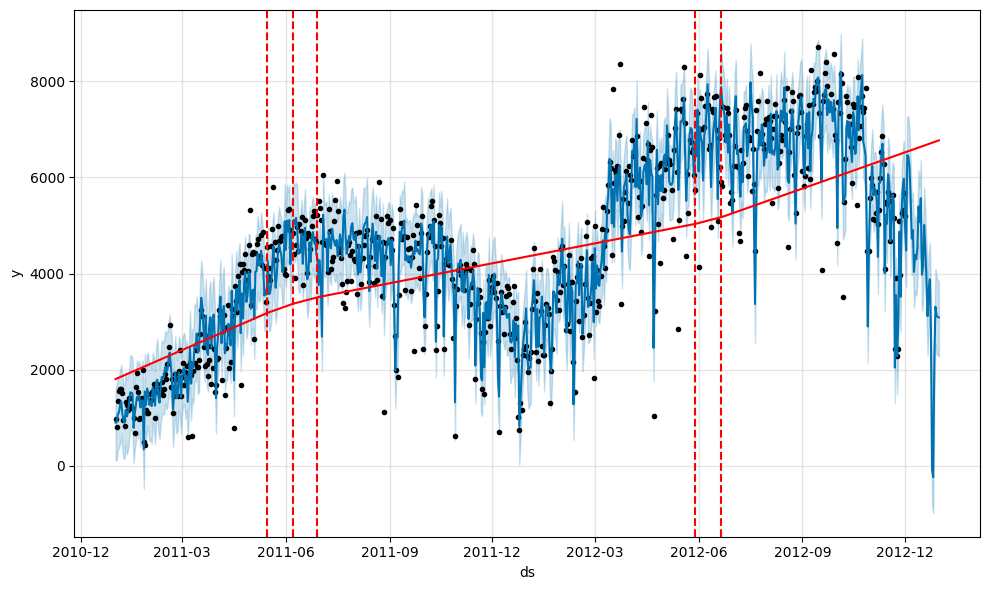

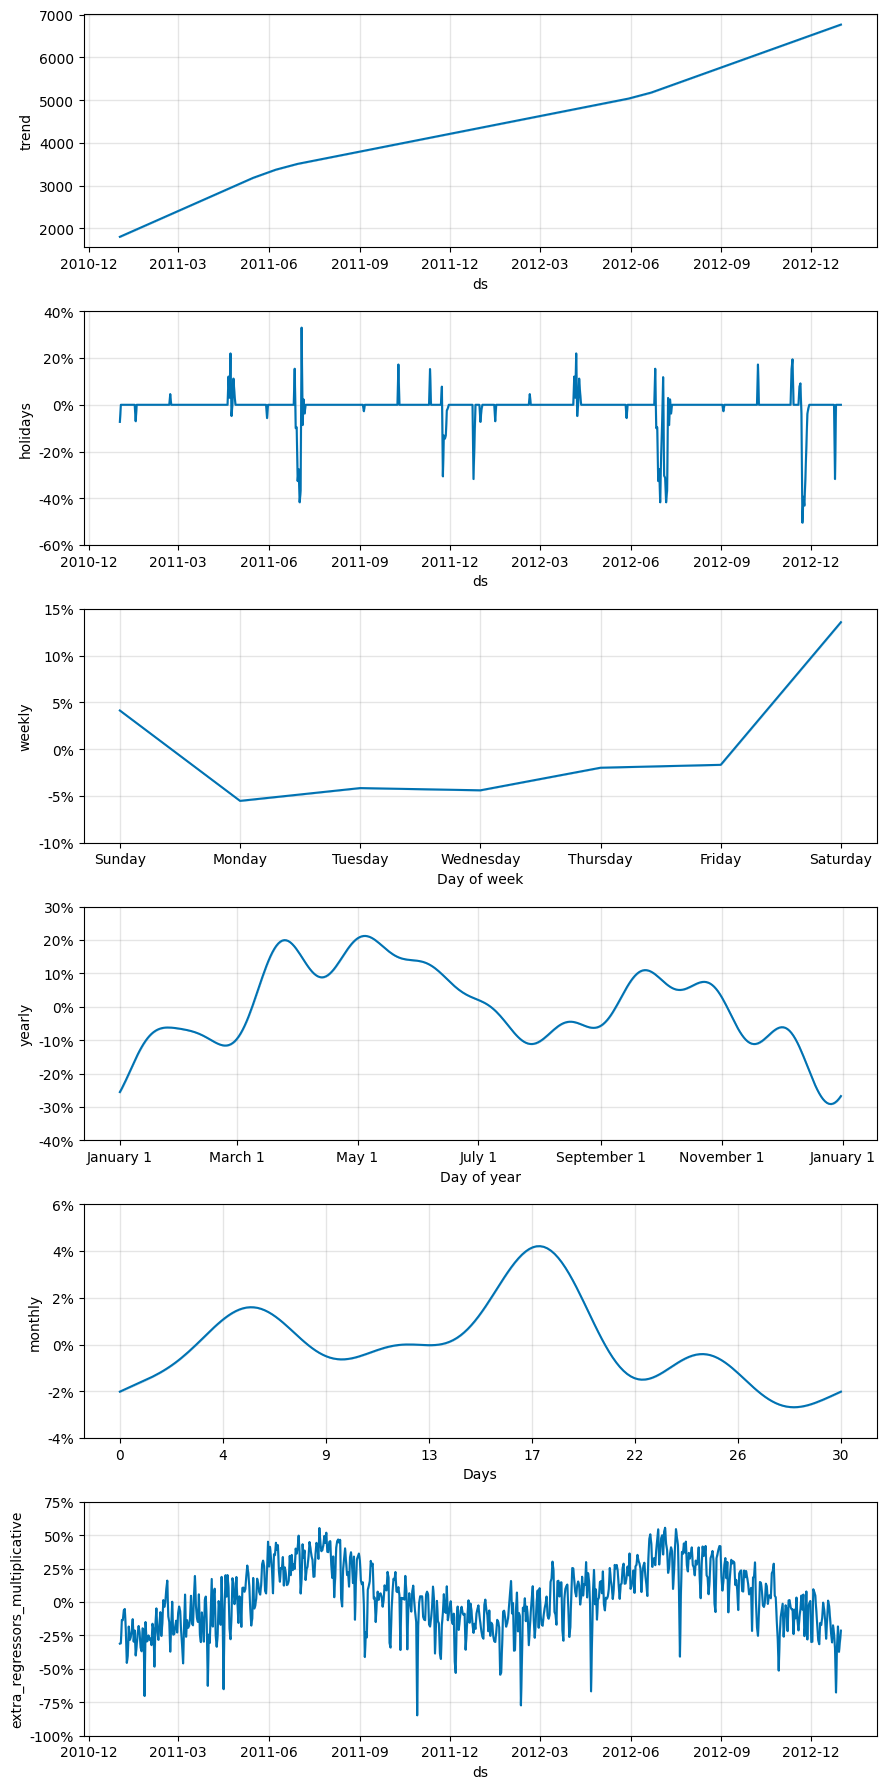

In [ ]:
# Using the Prophet model to generate predictions for future timestamps
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

fig = m.plot_components(forecast)

### Perform Cross Validation ###

To better explain what is happening in cross_validation(). Let's use concrete values.

Example:
- Suppose you have 4 years (1461 days) of daily data.
- initial = '730 days' (2 years)
- horizon = '90 days' (3 months)
- period = '30 days' (1 month)


Training Fold will look like:
- [ Training Fold 1: Days 0-730 ] -> [Predict Days 731-820]

Then we step forward by period (30 days):

- [ Training Fold 2: Days 0-760 ] -> [Predict Days 761-850]

- [ Training Fold 3: Days 0-790 ] -> [Predict Days 791-880]
- ... and so on until the end of the data.

In [ ]:
train.shape[0] - 180

521

In [ ]:
period = '15 days'      # Step size between cutoff dates
initial = '521 days'    # Size of initial training period
horizon = '30 days'     # Forecast horizon

In [ ]:
# Apply the CV to the model
df_cv = cross_validation(model = m, period = period, initial = initial, horizon = horizon, parallel = 'processes')

INFO:prophet:Making 10 forecasts with cutoffs between 2012-06-19 00:00:00 and 2012-11-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f84cd7469d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaqn4v1ms/tf_hsuva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaqn4v1ms/gpo8vr50.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaqn4v1ms/w037j5nc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58285', 'data', 'file=/tmp/tmpaqn4v1ms/gpo8vr50.json', 'init=/tmp/tmpaqn4v1ms/w037j5nc.json', 'output', 'file=/tmp/tmpaqn4v1ms/prophet_modelnafb9_1w/prophet_model-20250819105000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaqn4v1ms/z72s4mf_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:runnin

In [ ]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.576946e+06,1255.764934,938.651919,0.164438,0.090287,0.161308,0.600000
1,4 days,1.418784e+06,1191.127316,864.165380,0.145462,0.090287,0.144865,0.633333
2,5 days,1.368166e+06,1169.686467,894.795350,0.144785,0.094890,0.142050,0.566667
3,6 days,1.168489e+06,1080.966495,841.914017,0.131568,0.091834,0.133610,0.566667
4,7 days,1.191491e+06,1091.554466,836.795369,0.127025,0.092889,0.132580,0.533333
5,8 days,9.739739e+05,986.901172,738.783454,0.104287,0.083080,0.113644,0.566667
6,9 days,8.780807e+05,937.059607,744.397371,0.104360,0.083826,0.110592,0.533333
7,10 days,1.382101e+06,1175.627710,875.368491,0.127071,0.096339,0.127914,0.533333
8,11 days,1.437980e+06,1199.158079,887.560684,0.133419,0.090351,0.132204,0.600000
9,12 days,1.723966e+06,1312.998841,988.484659,0.154964,0.094465,0.158191,0.566667


In [ ]:
# RMSE and MAPE
rmse = round(performance_metrics(df_cv)['rmse'].mean(),0)
mape = round(performance_metrics(df_cv)['mape'].mean()* 100 ,2)
print(f"The RMSE is {rmse}")
print(f"The MAPE is {mape} %")

The RMSE is 1260.0
The MAPE is 15.71 %


/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


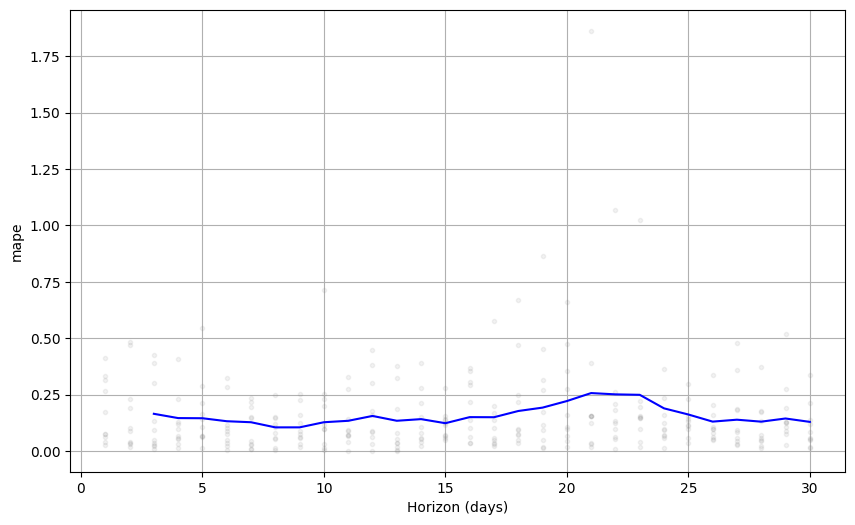

In [ ]:
plot_cross_validation_metric(df_cv, metric = 'mape');

### Exploring the Error ###

In [ ]:
# Compute the Error / deviation
df_cv['deviation'] = df_cv['yhat'] - df_cv['y']
df_cv['deviation_%'] = (df_cv['yhat'] / df_cv['y'] - 1) *100

In [ ]:
# Days with the highest percentage deviation
df_cv.sort_values(by = 'deviation_%', ascending = False).head(20)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,deviation,deviation_%
18,2012-07-08,8714.961003,8012.186303,9446.434000,4672.0,2012-06-19,4042.961003,86.535980
9,2012-06-29,9352.596958,8633.015470,10082.138449,5463.0,2012-06-19,3889.596958,71.198919
17,2012-07-07,8074.345312,7409.573972,8832.499896,4840.0,2012-06-19,3234.345312,66.825316
214,2012-10-07,5422.369367,4640.690284,6175.346228,3510.0,2012-10-02,1912.369367,54.483458
199,2012-10-07,5174.811118,4441.122639,5952.341425,3510.0,2012-09-17,1664.811118,47.430516
1,2012-06-21,8675.378147,7957.606204,9436.584532,5905.0,2012-06-19,2770.378147,46.915803
2,2012-06-22,8300.792540,7560.503874,9007.272559,5823.0,2012-06-19,2477.792540,42.551821
180,2012-09-18,5750.185641,4980.986037,6578.693498,4073.0,2012-09-17,1677.185641,41.178140
33,2012-07-08,6576.998203,5848.703286,7282.952092,4672.0,2012-07-04,1904.998203,40.774790
11,2012-07-01,7640.497093,6962.626558,8334.079320,5531.0,2012-06-19,2109.497093,38.139524


We can explore this deviations, specially on the dates October 28, 29, 30 2012. Upon checking these dates, there are events in washington that might affect our data, it seems the Hurricane Sandy has made a landfall on Washing DC. Which explains the high deviations on the predicted demand versus the actual.

Another series of dates that can be investigated are November 22, 23, 24, 25 of 2012, which falls on Thanksgivings and Black Friday Sale.

July 7-8 of 2012 which are Independence Day weekend.

### Hyper parameter Tuning ###

In [ ]:
# Define the parameter grid to search
param_grid = {
    'changepoint_prior_scale': [0.001, 0.05, 0.5],
    'seasonality_prior_scale': [10, 20],
    'holidays_prior_scale': [10, 20],
    'seasonality_mode' : ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(model = m, period = period, initial = initial, horizon = horizon, parallel = 'processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaqn4v1ms/suggxtoq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaqn4v1ms/mbwupi9n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80855', 'data', 'file=/tmp/tmpaqn4v1ms/suggxtoq.json', 'init=/tmp/tmpaqn4v1ms/mbwupi9n.json', 'output', 'file=/tmp/tmpaqn4v1ms/prophet_modelbbazhvse/prophet_model-20250819105005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:50:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:50:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
10:50:05 - cmdstanpy - ERROR - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.001                       10                    10   
1                     0.001                       10                    10   
2                     0.001                       10                    20   
3                     0.001                       10                    20   
4                     0.001                       20                    10   
5                     0.001                       20                    10   
6                     0.001                       20                    20   
7                     0.001                       20                    20   
8                     0.050                       10                    10   
9                     0.050                       10                    10   
10                    0.050                       10                    20   
11                    0.050                       10            

In [ ]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,rmse
0,0.001,10,10,additive,1370.630098
1,0.001,10,10,multiplicative,1394.995951
2,0.001,10,20,additive,1370.630098
3,0.001,10,20,multiplicative,1394.995951
4,0.001,20,10,additive,1414.185926
5,0.001,20,10,multiplicative,1358.481149
6,0.001,20,20,additive,1414.185926
7,0.001,20,20,multiplicative,1358.481149
8,0.050,10,10,additive,1571.825231
9,0.050,10,10,multiplicative,1586.476324


In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive'}


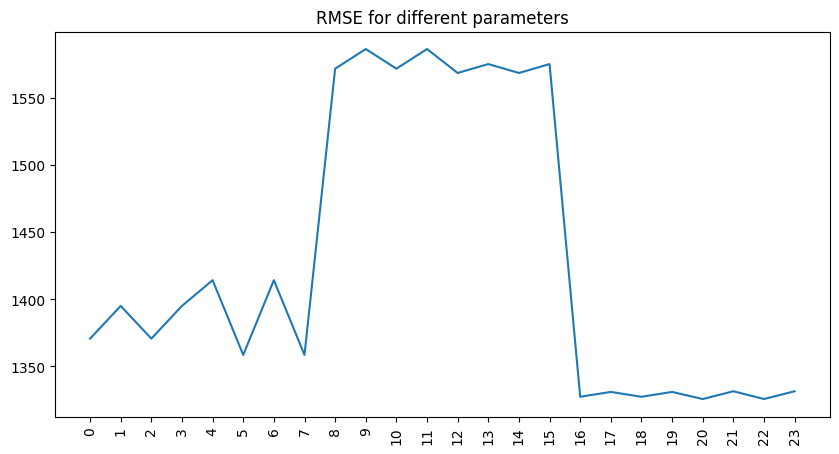

In [ ]:
# plotting the mape for the different parameters
plt.figure(figsize=(10, 5))
plt.plot(tuning_results['rmse'])
plt.xticks(range(len(tuning_results)), tuning_results.index, rotation=90)
plt.title('RMSE for different parameters')
plt.show()

### FINAL MODEL ###

In [ ]:
# Building the Prophet model
m = Prophet(
    yearly_seasonality=True,     # Include yearly seasonality
    weekly_seasonality=True,     # Include weekly seasonality
    holidays=holidays,           # Include holiday effects
    seasonality_mode="additive",  # Use multiplicative seasonality
    seasonality_prior_scale=20,  # Increase flexibility of seasonality
    holidays_prior_scale=10,     # Increase impact of holidays
    changepoint_prior_scale=0.5 # Control flexibility in detecting trend changes
)

# Add built in country holidays
m.add_country_holidays(country_name='US')

# Add monthly seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Add additional regressors (external factors) to the model
m.add_regressor("workingday")
m.add_regressor("temp")
m.add_regressor("atemp")
m.add_regressor("hum")
m.add_regressor("windspeed")
m.add_regressor("weathersit_2")
m.add_regressor("weathersit_3")

m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyneczxyg/9gnath6g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyneczxyg/2_ec3a02.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29598', 'data', 'file=/tmp/tmpyneczxyg/9gnath6g.json', 'init=/tmp/tmpyneczxyg/2_ec3a02.json', 'output', 'file=/tmp/tmpyneczxyg/prophet_modelriogl3da/prophet_model-20250829065634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:56:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:56:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


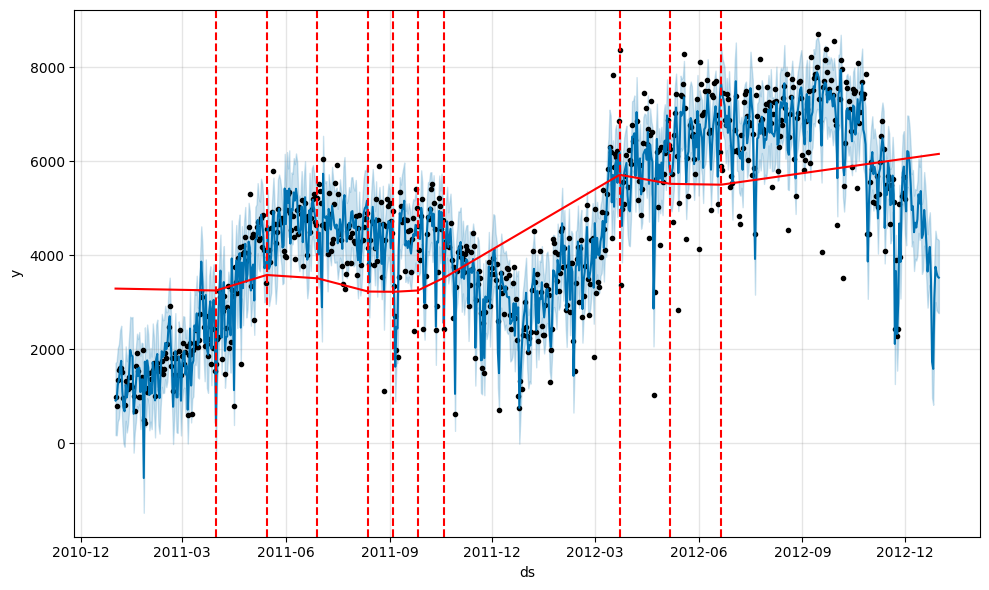

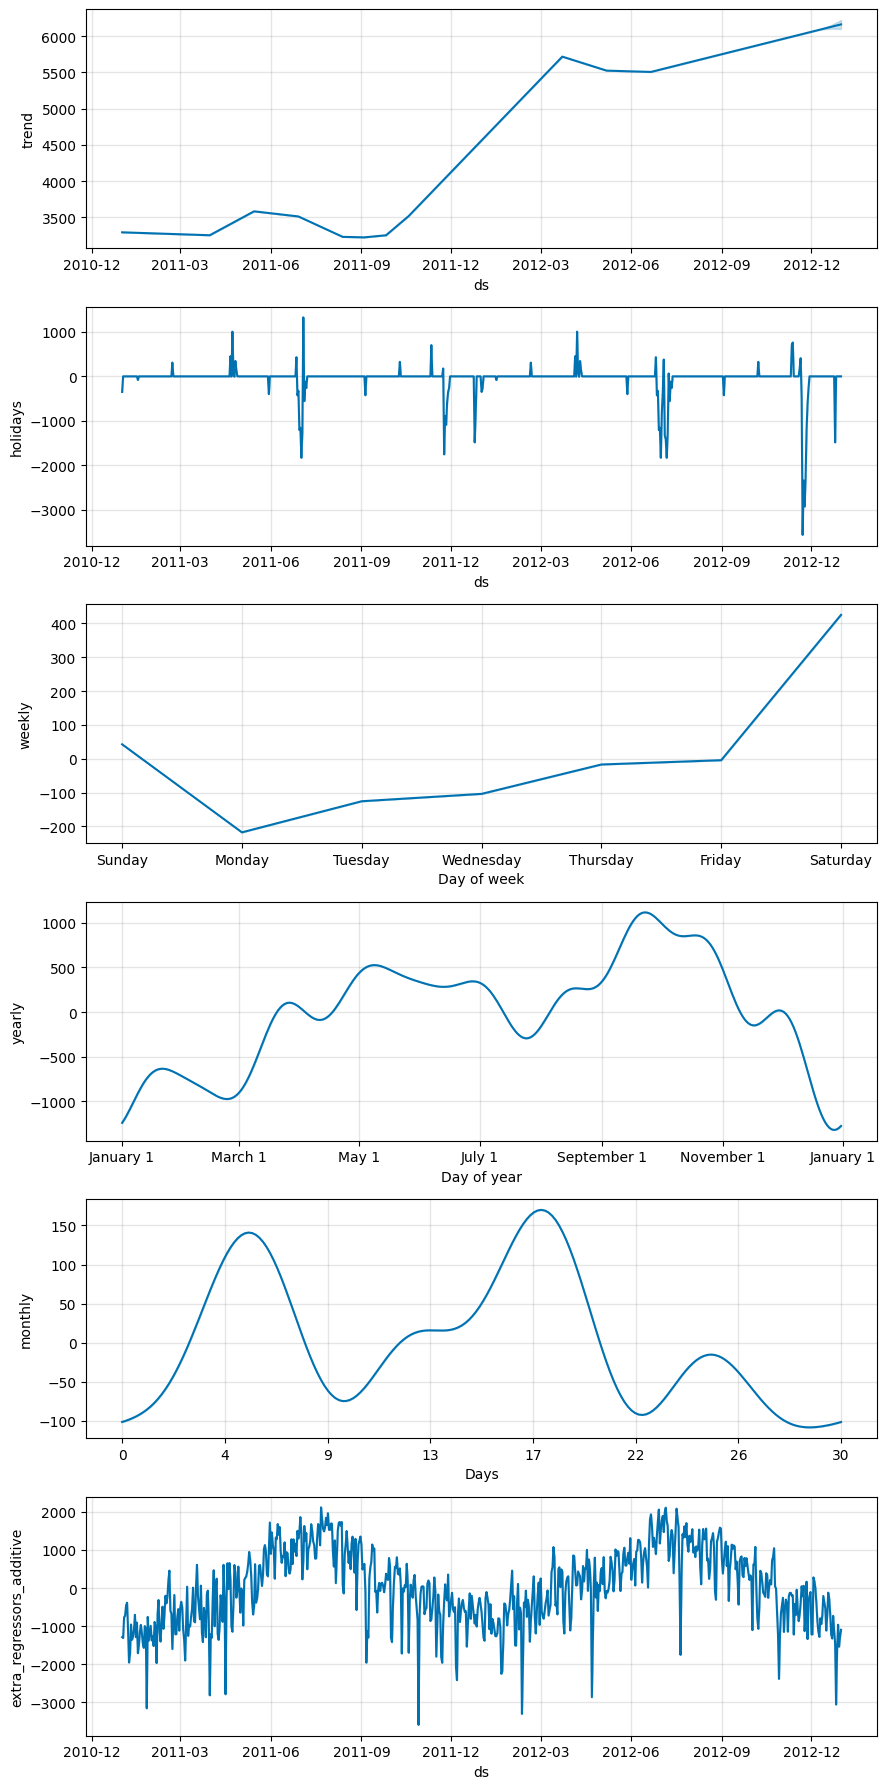

In [ ]:
# Using the Prophet model to generate predictions for future timestamps
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

fig = m.plot_components(forecast)

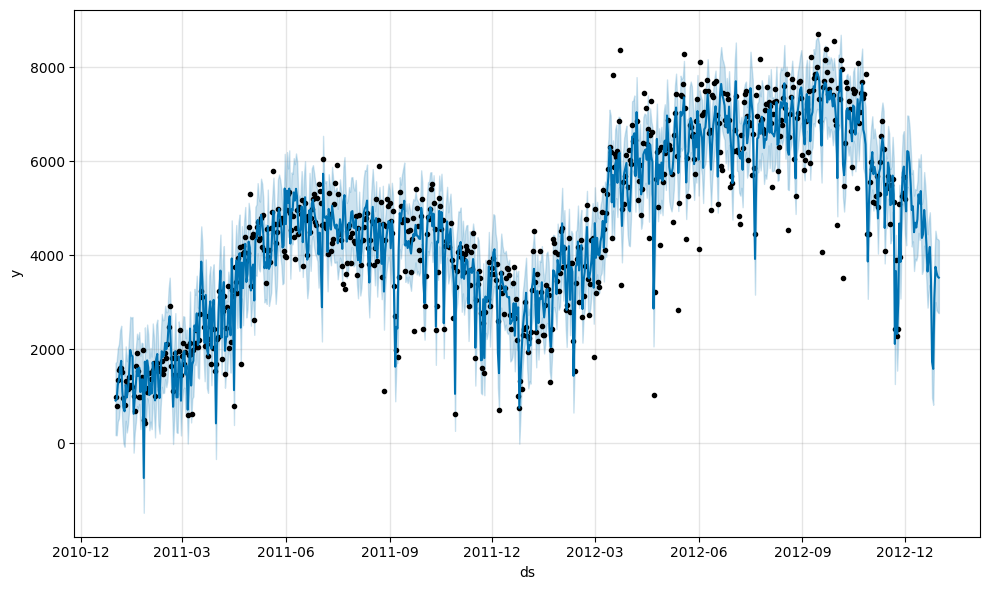

In [ ]:
# Visualize forecast plot with uncertainty bounds
m.plot(forecast)
plt.show()

In [ ]:
# Interactive visualization (using Plotly)
from prophet.plot import plot_plotly
import plotly.offline as py

# Use Prophet's plot_plotly function to generate an interactive plotly figure
fig = plot_plotly(m, forecast)
# Use Plotly's offline mode to display the interactive plotly figure
py.iplot(fig)

In [ ]:
forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']].tail(30)

,ds,yhat_lower,yhat_upper,yhat
701,2012-12-02,4149.201414,5713.728531,4888.323612
702,2012-12-03,5307.990249,6902.698515,6086.322686
703,2012-12-04,5262.608999,6797.213826,6049.644531
704,2012-12-05,5090.088946,6707.986772,5872.031772
705,2012-12-06,4719.788082,6321.588848,5514.038143
706,2012-12-07,4205.949508,5761.377438,4999.006909
707,2012-12-08,4352.269305,5851.929783,5092.923392
708,2012-12-09,3677.431263,5283.746838,4518.184915
709,2012-12-10,3917.145180,5468.650050,4676.036305
710,2012-12-11,3860.930653,5342.901462,4579.556937
